## Import all the required packages

In [1]:
import os
import glob

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

% matplotlib inline


## Define all the functions
### feature functions

In [2]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys', 
                                  visualise=vis, transform_sqrt=False, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys', 
                       visualise=vis, transform_sqrt=False, feature_vector=feature_vec)
        return features


### Features extraction functions

In [3]:
def convert_color(image, color_space):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    
    return feature_image

# Define a function to extract features from a list of images
# Have this function call bin_spatial(), color_hist() and get_hog_features
# Used for training the model
def extract_features(imgs, 
        color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, color_space)  

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orient, pix_per_cell, cell_per_block, 
                                                vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# version of the above function for a single image
# Used for testing the image data sets or videos
def single_img_features(img, 
        color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
        spatial_feat=True, hist_feat=True, hog_feat=True, 
        vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    hog_image = None
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        counter=0
        if hog_channel == 'ALL':
            hog_features = []
            #print(len(hog_features))
            #print("sif4_len hog feature ini", len(hog_features))
            for channel in range(feature_image.shape[2]):
                #counter += 1
                #print(counter)
                #print("sif5_len hog feature antes:",len(hog_features))
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))  
                #print("sif6_len hog feature depois:",len(hog_features))
            #print(len(hog_features))
            #hog_feat_array = np.asarray(hog_features)
            #print(hog_feat_array.shape)
            #print("sif7_Len de hog", len(hog_features),"sif8_Tipo de hog", type(hog_features))
            #hog_feat_array = np.asarray(hog_features)
            #print("sif9_shape depois de conversão para numpy array", hog_feat_array.shape)
            #hog_feat_array = np.expand_dims(hog_feat_array, axis=1)
            #print("sif10_shape depois de conversão para numpy array", hog_feat_array.shape)
            #print(hog_features)
            #hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                                           orient, pix_per_cell, cell_per_block, 
                                                           vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orient, pix_per_cell, cell_per_block, 
                                                vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    
    #9) Return concatenated array of features
    #print("sif11_len depois de HOG:", len(img_features))
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


### Search window functions

In [4]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1 
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


### Bounding boxes drawing

In [5]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Image visualization

In [6]:
# Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

### Data set analysis

In [7]:
set_dir = 'examples/set/'
vehicle_dir = 'vehicles/'
non_vehicle_dir = 'non-vehicles/'

v_image_types = os.listdir(set_dir+vehicle_dir)
nv_image_types = os.listdir(set_dir+non_vehicle_dir)
cars = []
notcars = []

for imtype in v_image_types:
    cars.extend(glob.glob(set_dir+vehicle_dir+imtype+'/*'))

print("Car images count:", len(cars))
#with open("cars.txt", 'w') as f:
#    for fn in cars:
#        f.write(fn+'\n')
        
for imtype in nv_image_types:
    notcars.extend(glob.glob(set_dir+non_vehicle_dir+imtype+'/*'))

print("Not car images count:", len(notcars))
#with open("notcars.txt", 'w') as f:
#    for fn in notcars:
#        f.write(fn+'\n')


Car image count: 8792
Not car image count: 8968


### Parameters Setup

In [8]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

## Function validation
### Test features extraction on a randomly chosen image for both cars and non-cars
#### Hog feature

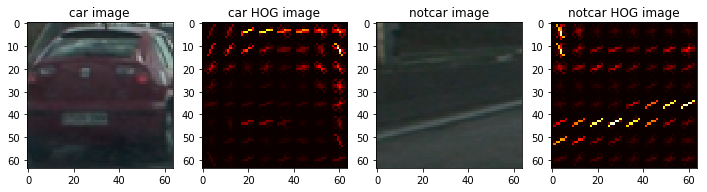

In [9]:
# choose random image for car and notcar
# Cannot be used with hog_channel = "ALL" because single_img_features function definition doesn't support it
# together with visualization = True

car_index = np.random.randint(0, len(cars))
notcar_index = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_index])
notcar_image = mpimg.imread(notcars[notcar_index])

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, hog_channel=0, 
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, 
                                                  vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                                                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                        cell_per_block=cell_per_block, hog_channel=0, 
                                                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, 
                                                        vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

### train model with data set and check its size and accuracy

In [10]:
t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)

test_cars = cars#np.array(cars)[random_idxs]   #cars#
test_notcars = notcars#np.array(notcars)[random_idxs] #notcars#

print('Feature extraction is about to start...')

car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                hog_feat=hog_feat)

print('Done with car images, starting with non-car images...')

notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                   hog_feat=hog_feat)

print(time.time()-t, 'seconds to extract features from car and non-car data sets')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

#print('Using spatial binning of:',spatial,'and', histbin,'histogram bins')
print('Using: ', orient, ' orientations, ', pix_per_cell, 
      ' pixels per cell, ', cell_per_block, ' cells per block, ', 
      hist_bins, ' histogram bins, ', spatial_size, ' spatial sampling.')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Feature extractiion is about to start...
212.86272525787354 seconds to extract features from car and non-car data sets
Using:  9  orientations,  8  pixels per cell,  2  cells per block,  16  histogram bins,  (16, 16)  spatial sampling.
Feature vector length: 6108
26.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9893


### Test car detection over small image test data set

In [11]:
testFilesPath = 'images_video/vehicle_det_examples/*' # jpg images folder (detail: system has been trained with png images)
testFilesList = glob.glob(testFilesPath)              # outputs file list: "python list type"

0.7957479953765869 seconds to process one image searching  60  windows. Found  1  window(s)

0.7820546627044678 seconds to process one image searching  60  windows. Found  3  window(s)

0.7741189002990723 seconds to process one image searching  60  windows. Found  0  window(s)

0.7754032611846924 seconds to process one image searching  60  windows. Found  12  window(s)

0.7734560966491699 seconds to process one image searching  60  windows. Found  1  window(s)

0.7715601921081543 seconds to process one image searching  60  windows. Found  12  window(s)

0.7714200019836426 seconds to process one image searching  60  windows. Found  13  window(s)

0.7735130786895752 seconds to process one image searching  60  windows. Found  12  window(s)



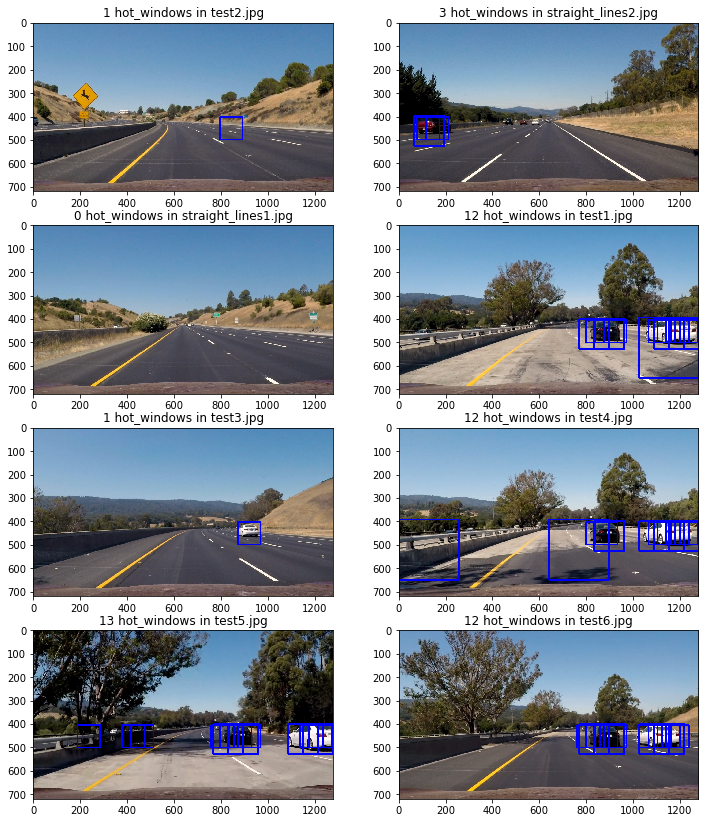

In [12]:
images = []
titles = []
y_start_stop1 = [394, 650]
xy_window1 = (256,256)
overlap1 = 0.5
y_start_stop2 = [400, 528]
xy_window2 = (128,128)
overlap2 = 0.5
y_start_stop3 = [404, 500]
xy_window3 = (96,96)
overlap3 = 0.6

for img_file in testFilesList:
    t1 = time.time()
    img = mpimg.imread(img_file)       # uses the file path (python str type) to read file. Outputs Numpy Array type
    draw_img = np.copy(img)            # create a copy of image
    img = img.astype(np.float32)/255   # Normalize image values to allow JPG (0-255) images on PNG (0-1) model
    
    #windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96,96), xy_overlap=(overlap, overlap))
    windows1 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop1, xy_window=xy_window1, xy_overlap=(overlap1, overlap1))
    windows2 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop2, xy_window=xy_window2, xy_overlap=(overlap2, overlap2))
    windows3 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop3, xy_window=xy_window3, xy_overlap=(overlap3, overlap3))
    windows = []
    windows.append(windows1)
    windows.append(windows2)
    windows.append(windows3)
    windows = [item for windows_type in windows for item in windows_type]
        
    hot_windows = search_windows(img, windows, svc, X_scaler, 
                                 color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    
    windows_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    
    images.append(windows_img)
    titles.append(str(len(hot_windows))+" hot_windows in "+os.path.basename(img_file))
    
    print(time.time()-t1, 'seconds to process one image searching ', len(windows), ' windows. Found ',len(hot_windows)," window(s)" )
    print("")

fig = plt.figure(figsize=(12,18))
visualize(fig, 5, 2, images, titles)

In [13]:
def convert_color_s(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

### Create heatmap based on detections

In [18]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_center = ((np.min(nonzerox)+np.max(nonzerox))//2,(np.min(nonzeroy)+np.max(nonzeroy))//2)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
        cv2.circle(img, bbox_center, 50, (0,255,0), thickness=6, lineType=8, shift=0) 
    # Return the image
    return img

In [48]:
def find_cars_in_image(img,draw_img,ystart,window_size, scale, cells_per_step, pix_per_cell, cell_per_block, orient, count, svc, X_scaler, heatmap):
    
    features_per_block = orient * cell_per_block**2
    window = 64
    blocks_per_window = (window // pix_per_cell) - 1
    increased_detection = 16
    
    area_of_interest = img[ystart:ystart+window_size,:,:]
    color_converted_img = convert_color_s(area_of_interest, conv='RGB2YCrCb')
    imshape = color_converted_img.shape
    img = cv2.resize(color_converted_img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    #print(imshape)
    #print(img.shape)
    #plt.imshow(img)
    #plt.show()
    
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    Xsteps = (img.shape[1] - window) // pix_per_cell // cells_per_step
    Ysteps = (img.shape[0] - window) // pix_per_cell // cells_per_step
    
    for x_var in range(Xsteps+1):
        for y_var in range(Ysteps+1):
            count += 1
            ypos = y_var*cells_per_step
            xpos = x_var*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+blocks_per_window, xpos:xpos+blocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+blocks_per_window, xpos:xpos+blocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+blocks_per_window, xpos:xpos+blocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            #subimg = cv2.resize(img1[ytop:ytop+window, xleft:xleft+window], (64,64)) 
            subimg = img[ytop:ytop+window, xleft:xleft+window]
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            all_boxes.append(((xleft*scale, ytop*scale+ystart),(xleft*scale+window*scale,ytop*scale+window*scale+ystart)))
            
            if test_prediction == 1:
                #print("CAR FOUND")
                #print(ystart)
                #plt.imshow(subimg)
                #plt.show()
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #plt.imshow(draw_img)
                #plt.show()
                cv2.rectangle(draw_img, (xbox_left, ystart + ytop_draw), (xbox_left + win_draw, ystart + ytop_draw + win_draw),(255,0,255),6)
                #plt.imshow(draw_img)
                #plt.show()
                img_boxes.append(((xbox_left, ystart + ytop_draw), (xbox_left + win_draw, ystart + ytop_draw + win_draw)))
                #print("heatmap max antes",np.amax(heatmap))
                #heatmap[ystart + ytop_draw : ystart + ytop_draw + win_draw, xbox_left : xbox_left + win_draw] += 1
                heatmap[ystart + ytop_draw - increased_detection : ystart + ytop_draw + win_draw + increased_detection, xbox_left - increased_detection : xbox_left + win_draw + increased_detection] += 1
                #plt.imshow(heatmap, cmap="hot")
                #plt.show()
                #print("heatmap max depois",np.amax(heatmap))
    
    return img_boxes, heatmap, count, draw_img

0.43763041496276855 seconds to run, total windows = 156  ; Detection count: 0
0.4392256736755371 seconds to run, total windows = 156  ; Detection count: 1
0.4374692440032959 seconds to run, total windows = 156  ; Detection count: 0
0.43869471549987793 seconds to run, total windows = 156  ; Detection count: 3
0.4388456344604492 seconds to run, total windows = 156  ; Detection count: 1
0.4382960796356201 seconds to run, total windows = 156  ; Detection count: 3
0.44062185287475586 seconds to run, total windows = 156  ; Detection count: 4
0.4423830509185791 seconds to run, total windows = 156  ; Detection count: 1


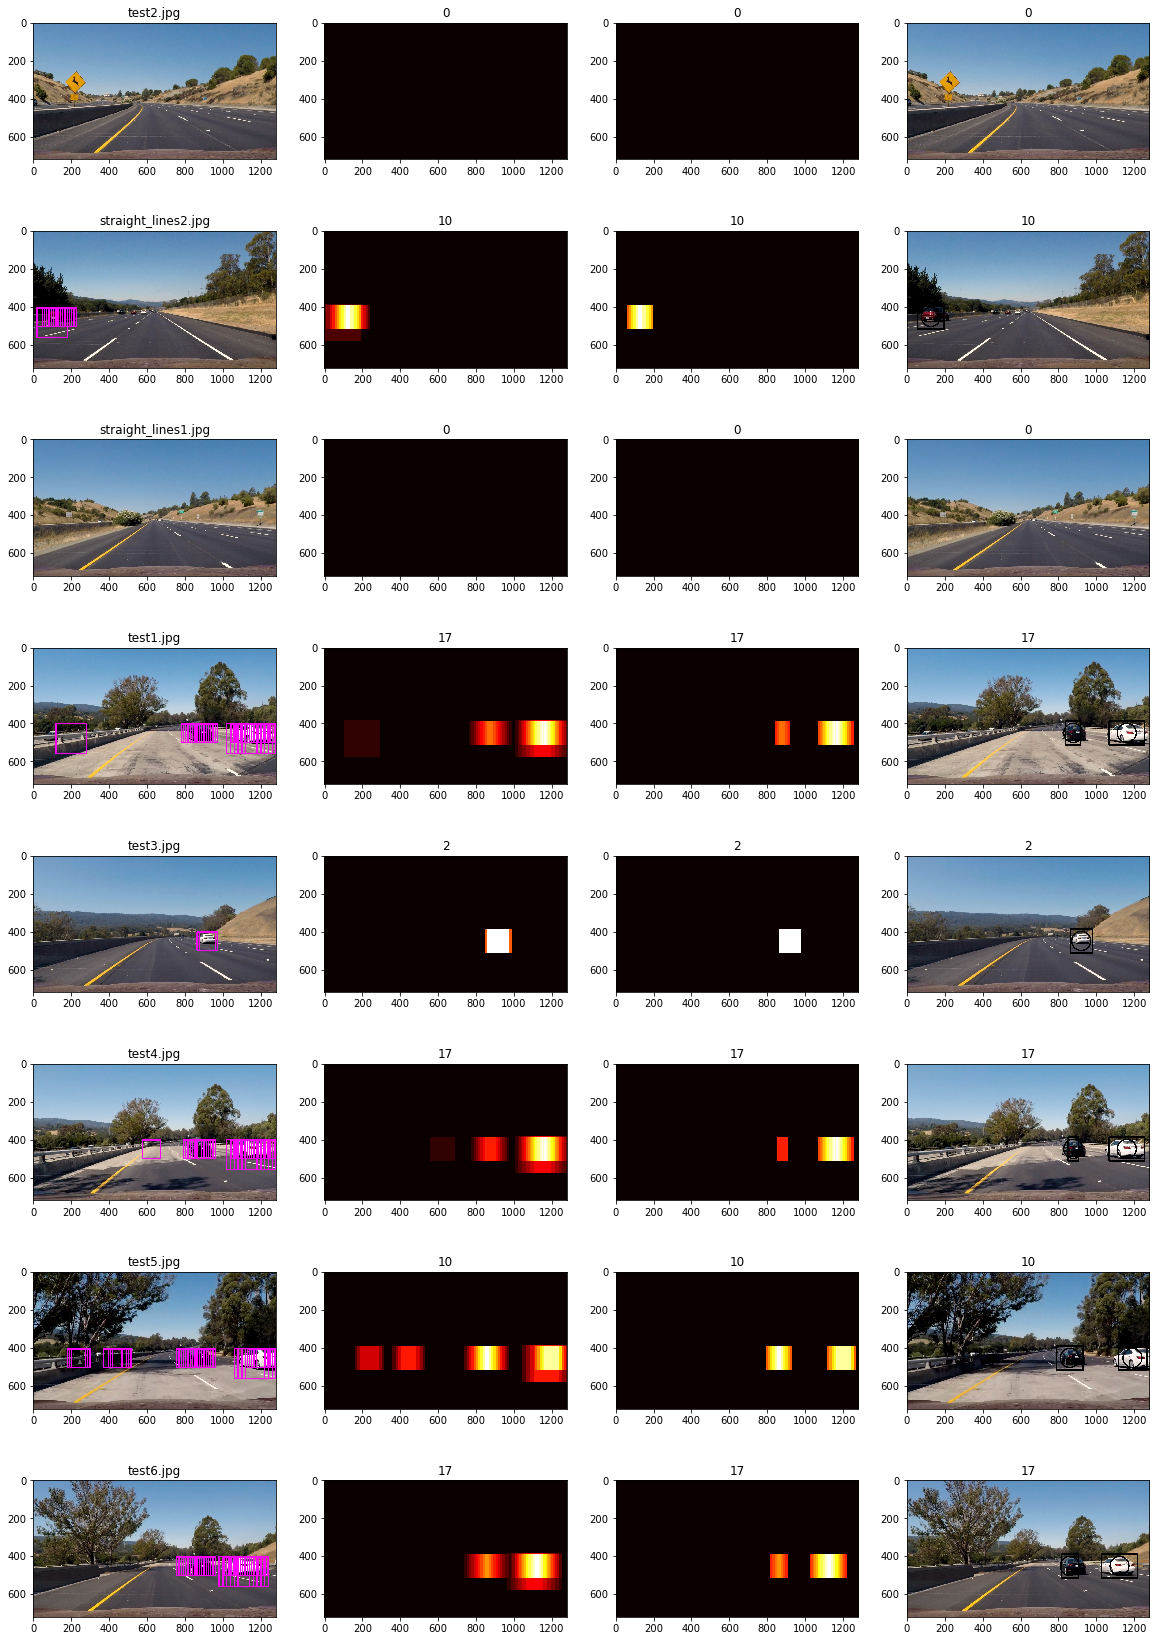

In [53]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

for img_file in testFilesList:
    img_boxes = []
    all_boxes = []
    find_variables = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_file)
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    cells_per_step = 1   # instead of overlap, define how many cells to step
    
    #pipeline
    
    #ystart = 394
    #window_size = 256
    #scale = 4
    #find_variables.append((ystart, window_size, scale))
    
    #ystart = 396
    #window_size = 224
    #scale = 3.5
    #find_variables.append((ystart, window_size, scale))
    
    #ystart = 398
    #window_size = 192
    #scale = 3
    #find_variables.append((ystart, window_size, scale))
    
    ystart = 400
    window_size = 160
    scale = 2.5
    find_variables.append((ystart, window_size, scale))
    
    #ystart = 402
    #window_size = 128
    #scale = 2
    #find_variables.append((ystart, window_size, scale))
    
    ystart = 404
    window_size = 96
    scale = 1.5
    find_variables.append((ystart, window_size, scale))
    
    #ystart = 436
    #window_size = 96
    #scale = 1.5
    #find_variables.append((ystart, window_size, scale))
    
    #ystart = 406
    #window_size = 64
    #scale = 1
    #find_variables.append((ystart, window_size, scale))
    
    #ystart = 438
    #window_size = 64
    #scale = 1
    #find_variables.append((ystart, window_size, scale))
    
    for i in range(len(find_variables)):
        img_boxes_tmp, heatmap, count, draw_img = find_cars_in_image(img, draw_img, find_variables[i][0], find_variables[i][1], find_variables[i][2], cells_per_step, pix_per_cell, cell_per_block, orient, count, svc, X_scaler, heatmap)
        img_boxes.append(img_boxes_tmp)
        #heatmap = np.add(heatmap, heatmap_tmp)
        #count += count_tmp
        
    labels = label(heatmap)
    print(time.time()-t, 'seconds to run, total windows =', count, " ; Detection count:", labels[1])

    heatmap_thresholded = np.copy(heatmap)
    
    out_images.append(draw_img)
    out_titles.append(os.path.basename(img_file))
    
    out_images.append(heatmap)
    out_titles.append(np.amax(heatmap))
    
    out_images.append(apply_threshold(heatmap_thresholded, np.amax(heatmap)//2.5))
    out_titles.append(np.amax(apply_threshold(heatmap_thresholded, 1)))
    
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    
    labels = label(apply_threshold(heatmap_thresholded, np.amax(heatmap)//2.5))  
    draw_img_label = draw_labeled_bboxes(img, labels)
    out_images.append(draw_img_label)
    out_titles.append(np.amax(apply_threshold(heatmap_thresholded, 1)))

fig = plt.figure(figsize=(20,30))
visualize(fig, 8, 4, out_images, out_titles)



### Define a class for vehicle classification

In [ ]:
# Define a class to receive the characteristics of each vehicle detection
# Objects defined as "Vehicles" will be where multiple overlapping detections exist in the heatmap
class Vehicle():
    def __init__(self):
        self.detected = False      # was the vehicle detected in the last iteration?
        self.n_detections = 0      # Number of times this vehicle has been?
        self.n_nondetections = 0   # number of consecutive times this car a«has not been detected
        self.xpixels = None        # pixel x value in the last detection
        self.ypixels = None        # pixel y value in the last detection
        self.recent_xfitted = []   # x position of the last n fits of the bounding box
        self.bestx = None          # average x position of the last n fits
        self.recent_yfitted = []   # y position of the last n fits of the bounding box
        self.besty = None          # average y position of the last n fits
        self.recent_wfitted = []   # width of the last n fits of the bounding box
        self.bestw = None          # average width of the last n fits
        self.recent_hfitted = []   # height of the last n fits of the bounding box
        self.besth = None          # average height of the last n fits
        
        
        

In [ ]:
carslist = []
carslist.append(Vehicle())

#### Define other functions

In [ ]:

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

### Test complete car search over test data set

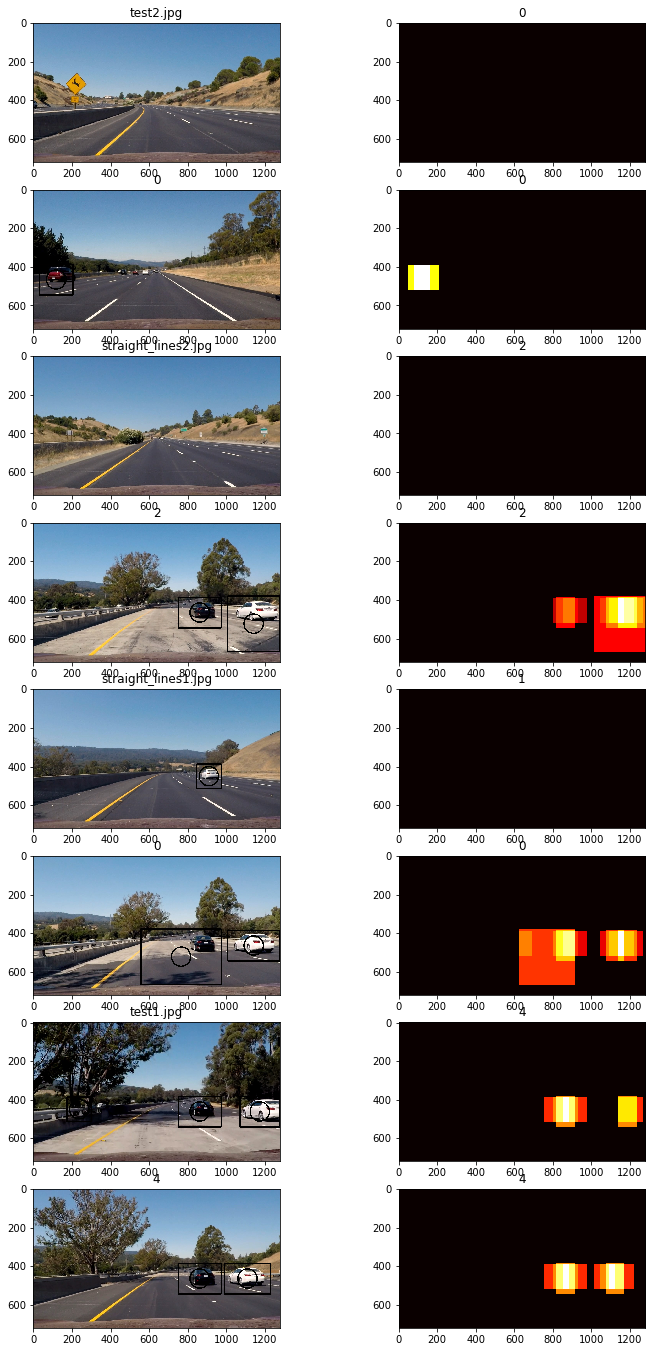

In [20]:
out_images = []
out_maps = []
find_variables = []

#ystart = 400
#ystop = 656
#scale = 1

ystart = 394
window_size = 256
scale = 4
find_variables.append((ystart, window_size, scale))

ystart = 400
window_size = 128
scale = 2
find_variables.append((ystart, window_size, scale))

ystart = 404
window_size = 96
scale = 1.5
find_variables.append((ystart, window_size, scale))

for img_file in testFilesList:
    img = mpimg.imread(img_file)
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    #out_img, heat_map = find_cars(img, scale) 
    for i in range(len(find_variables)):
        img_boxes_tmp, heatmap_tmp, count_tmp, draw_img = find_cars_in_image(img, draw_img, find_variables[i][0], find_variables[i][1], find_variables[i][2], cells_per_step, pix_per_cell, cell_per_block, orient, count, svc, X_scaler, heatmap)
        #img_boxes.append(img_boxes_tmp)
        heatmap = np.add(heatmap, heatmap_tmp)
        #count += count_tmp
    labels = label(heatmap)  
    #print(np.sum(heat_map))
    #print(np.sum(apply_threshold(heat_map, 1)))
    #print(np.sum(apply_threshold(heat_map, 2)))
    #print(np.sum(apply_threshold(heat_map, 3)))
    #print(np.sum(apply_threshold(heat_map, 4)))
    #print("")
    
    draw_img = draw_labeled_bboxes(img, labels)
    out_images.append(draw_img)
    out_images.append(apply_threshold(heatmap, 5))  # threshold added to remove false positives
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

### Define pipeline

In [ ]:
fr2ame_count = 0
he2at_log = []

In [21]:
def process_image(img):
    
    global cells_per_step
    global pix_per_cell
    global cell_per_block
    global orient
    global svc
    global X_scaler
    
    global frame_count
    global heat_log
    
    compare_lenght = 1
    threshold_level = 1
    
    draw_img = np.copy(img)
    final_img = np.copy(img)
    
    time_heat = np.zeros_like(img[:,:,0])
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    find_variables = []
    count = 0
    
    #ystart = 394
    #window_size = 256
    #scale = 4
    #find_variables.append((ystart, window_size, scale))
    
    #ystart = 400
    #window_size = 128
    #scale = 2
    #find_variables.append((ystart, window_size, scale))
    
    ystart = 398
    window_size = 192
    scale = 3
    find_variables.append((ystart, window_size, scale))
    
    ystart = 404
    window_size = 96
    scale = 1.5
    find_variables.append((ystart, window_size, scale))
    
    for i in range(len(find_variables)):
        img_boxes_tmp, heatmap, count, draw_img = find_cars_in_image(img, draw_img, find_variables[i][0], find_variables[i][1], find_variables[i][2], cells_per_step, pix_per_cell, cell_per_block, orient, count, svc, X_scaler, heatmap)
        #img_boxes.append(img_boxes_tmp)
        #heatmap = np.add(heatmap, heatmap_tmp)
        #count += count_tmp
    
    #print("heat_log lenght before append ",len(heat_log))
    # save heat_map for each frame
    heat_log.append(heatmap)
    
    loop_end = frame_count - compare_lenght
    if loop_end < 1:
        loop_end = 1
    
    #print("heat_log lenght before for loop ",len(heat_log))
    # then compare consecutive frames (more than 2 if needed) like sum of them devided by the number of considered frames
    heat_weight = compare_lenght
    for i in range(frame_count, loop_end, -1):
        #print(i)
        #print("heat_log lenght inside for loop ",len(heat_log))
        time_heat = np.add(time_heat, heat_log[i] * heat_weight)
        heat_weight -= 1
    
    #heat_sum = np.divide(heat_sum, (frame_count - loop_end + 1))
    frame_count += 1
    # Threshold
    ind_sum = 0
    for i in range(frame_count - loop_end + 1):
        ind_sum += i 
    time_heat = apply_threshold(time_heat, threshold_level * compare_lenght)#2 * threshold_level * (frame_count - loop_end))
    
    # compare last one with average
    #heatmap = np.add(heat_sum, heatmap)
    #heatmap = np.divide(heatmap, 1)
    #heatmap = apply_threshold(heatmap, threshold_level)
    
    # drop detections that are not consistent
    #labels = label(time_heat)
    labels = label(time_heat)
    
    draw_img = draw_labeled_bboxes(final_img, labels)
    #print(len(labels))
    
    return draw_img

### Test pipeline (process_image) over the project video

In [22]:
frame_count = 0
heat_log = []

output_file = './output_images/output_project_video.mp4' 

##clip = VideoFileClip("project_video.mp4").subclip(0,5)
clip = VideoFileClip("test_video.mp4")#project_video.mp4").subclip(12,16)
#ADDED updated function name to process the images
output_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!

%time output_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ./output_images/output_project_video.mp4
[MoviePy] Writing video ./output_images/output_project_video.mp4


 97%|█████████▋| 38/39 [00:11<00:00,  3.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_project_video.mp4 

CPU times: user 11 s, sys: 112 ms, total: 11.2 s
Wall time: 11.8 s


In [23]:
frames = int(clip.fps * clip.duration)

print(clip.fps)
print(clip.duration)
print(frames)
print("")
print(frame_count)


25.0
1.52
38

39


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))